<h1>Malidup Benchmark</h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import sem
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

import matplotlib.pyplot as plt
%matplotlib inline

from plmalign.dataset.score import alignment_score, score_global_alignment, score_local_alignment
from plmalign.dataset.parse_mali import read_mali, read_mali_mammoth

from plmalign.dataset.utils import revstate_f, state_f
matrix = matlist.blosum62
def nw_f(x, y):
    alignments = pairwise2.align.globaldx(x, y, matrix)
    states = list(map(state_f, zip(list(alignments[0].seqA), list(alignments[0].seqB))))
    states = ''.join(list(map(revstate_f, states)))
    return states

def sw_f(x, y):
    alignments = pairwise2.align.localdx(x, y, matrix)
    states = list(map(state_f, zip(list(alignments[0][0]), list(alignments[0][1]))))
    states = ''.join(list(map(revstate_f, states)))
    return states

/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
malidup_root = './data/alignment_benchmark/malidup'

mammoth_dup_root = './data/alignment_benchmark/mammoth/malidup'

mali_root = malidup_root
mali_mammoth = mammoth_dup_root
benchmark = 'malidup'

<h3>Load manual alignment</h3>
<h3>Smith-Waterman and Needleman-Wunsch</h3>

In [3]:
# Load manual alignment
mammoth = read_mali_mammoth(mali_mammoth, report_ids=True)
manual = read_mali(mali_root, tool='manual', report_ids=True)
res = pd.merge(manual, mammoth, left_on='dir', right_on='pdb')
res = res[['0_x', '1_x', '2_x', '2_y', 'dir']]
res = res.rename(columns={'0_x' : 0, '1_x' : 1, '2_x' : 'manual', '2_y': 'mammoth'})
res = res[~res.set_index([0, 1]).index.duplicated(keep='first')]
res = res.set_index([0, 1])
coded = pd.read_csv('./data/alignment_benchmark/pdblistdup.csv', index_col=0)
res = pd.merge(res, coded, left_on='dir', right_index=True)

#Smith-Waterman and Needleman-Wunsch
sw     = res.reset_index().apply(lambda x: sw_f(x[0], x[1]), axis=1)
res['smith-waterman'] = sw.values

nw     = res.reset_index().apply(lambda x: nw_f(x[0], x[1]), axis=1)
res['needleman-wunsch'] = nw.values

<h3>Gnenrate ESM-1b & ProtT5 embedding</h3>

In [4]:
#ProtT5
sequences = set()
sw     = res.reset_index().apply(lambda x: sequences.add(x[0]), axis=1)
sw     = res.reset_index().apply(lambda x: sequences.add(x[1]), axis=1)
print(len(sequences))

fasta_file = 'data/alignment_benchmark/malidup/protein.fasta'
with open(fasta_file, 'w') as handle:
    for protein in sequences:
        handle.write(f">{protein}\n")
        handle.write(f"{protein}\n")

from plmalign.embedding_generate import prottrans_embedding_generate
import torch

embeddings = prottrans_embedding_generate(fasta_file)

final_embeddings = {}

output_file = 'data/alignment_benchmark/malidup/t5_embedding.pt'

torch.save(
    embeddings,
    output_file,
)

448


/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
##########################
Loading cached model from: data/model/Rostlab/prot_t5_xl_uniref50/
##########################


Some weights of the model checkpoint at data/model/Rostlab/prot_t5_xl_uniref50/ were not used when initializing T5EncoderModel: ['decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.21.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.18.layer.1.EncDecAttention.k.weight', 'decoder.block.16.layer.2.DenseReluDense.wi.weight', 'decoder.block.13.layer.1.layer_norm.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.9.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.0.SelfAttention.v.weight', 'decoder.block.16.layer.2.DenseReluDense.wo.weight', 'decoder.block.12.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'd

########################################
Total number of sequences: 448
Average sequence length: 115.40625
Number of sequences >1022: 0


  3%|▎         | 13/448 [00:05<03:06,  2.33it/s]

Embedded protein DLEAVKSDLEELMTSSQDWWPADYGHYGPLFIRMAWHSAGTYRTADGRGGAAGGRQRFAPINSWPDNANLDKARRLLLPIKQKYGQKISWADLMILAGNVAIESMGFKTFGYAGGREDAFEEDKAVNWGPEDEFETQERFDEPGEIQEGLGASVMGLIYVNPEGPDGNPDPEASAKNIRQTFDRMAMNDKETAALIAGGHTFGKVHGADDPEENLGPEPEAAPIEQQGLGWQNKNGNSKGGEMITSGIEGPWTQSPTEWDMGYINNLLDYEWEPEKGPGGAWQWAPKSEELKNSVPDAHDPDEKQTPMMLTTDIALKRDPDYREVMETFQENPMEFGMNFAKAWYKLTHRDMGPPERFLGPEVPDEEMIWQDPL with length 374 to emb. of shape: torch.Size([374, 1024])


100%|██████████| 448/448 [00:21<00:00, 20.97it/s]



############# STATS #############
Total number of embeddings: 448


In [5]:
#ESM-1b
sequences = set()
sw     = res.reset_index().apply(lambda x: sequences.add(x[0]), axis=1)
sw     = res.reset_index().apply(lambda x: sequences.add(x[1]), axis=1)
print(len(sequences))

fasta_file = 'data/alignment_benchmark/malidup/protein.fasta'
with open(fasta_file, 'w') as handle:
    for protein in sequences:
        handle.write(f">{protein}\n")
        handle.write(f"{protein}\n")

from plmalign.embedding_generate import esm_embedding_generate
import torch

embeddings = esm_embedding_generate(fasta_file)

final_embeddings = {}

output_file = 'data/alignment_benchmark/malidup/esm_embedding.pt'

torch.save(
    embeddings,
    output_file,
)

448
Transferred model to GPU
Read data/alignment_benchmark/malidup/protein.fasta with 448 sequences
Processing 1 of 5 batches (177 sequences)
Processing 2 of 5 batches (125 sequences)
Processing 3 of 5 batches (88 sequences)
Processing 4 of 5 batches (54 sequences)
Processing 5 of 5 batches (4 sequences)


<h3>PLMAlign (local and global) and pLM-BLAST (local and global)</h3>

In [6]:
import torch
from plmalign.plmalign import pairwise_align

embeddings = torch.load('data/alignment_benchmark/malidup/t5_embedding.pt')
#embeddings = torch.load('data/alignment_benchmark/malidup/esm_embedding.pt')

def plmblast_sw_f(x, y):
    x_e = embeddings[x]
    y_e = embeddings[y]
    _, alignments = pairwise_align(x_e, y_e, x, y, mode='local', method='plmblast')
    first_newline_index = alignments.find('\n')
    x_seq = alignments[:first_newline_index]
    second_newline_index = alignments.find('\n', first_newline_index + 1)
    y_seq = alignments[second_newline_index + 1:]
    states = list(map(state_f, zip(list(x_seq), list(y_seq))))
    states = ''.join(list(map(revstate_f, states)))
    return states

def plmblast_nw_f(x, y):
    x_e = embeddings[x]
    y_e = embeddings[y]
    _, alignments = pairwise_align(x_e, y_e, x, y, mode='global', method='plmblast')
    first_newline_index = alignments.find('\n')
    x_seq = alignments[:first_newline_index]
    second_newline_index = alignments.find('\n', first_newline_index + 1)
    y_seq = alignments[second_newline_index + 1:]
    states = list(map(state_f, zip(list(x_seq), list(y_seq))))
    states = ''.join(list(map(revstate_f, states)))
    return states

def plmalign_sw_f(x, y):
    x_e = embeddings[x]
    y_e = embeddings[y]
    _, alignments = pairwise_align(x_e, y_e, x, y, mode='local', method='plmalign')
    first_newline_index = alignments.find('\n')
    x_seq = alignments[:first_newline_index]
    second_newline_index = alignments.find('\n', first_newline_index + 1)
    y_seq = alignments[second_newline_index + 1:]
    states = list(map(state_f, zip(list(x_seq), list(y_seq))))
    states = ''.join(list(map(revstate_f, states)))
    return states

def plmalign_nw_f(x, y):
    x_e = embeddings[x]
    y_e = embeddings[y]
    _, alignments = pairwise_align(x_e, y_e, x, y, mode='global', method='plmalign')
    first_newline_index = alignments.find('\n')
    x_seq = alignments[:first_newline_index]
    second_newline_index = alignments.find('\n', first_newline_index + 1)
    y_seq = alignments[second_newline_index + 1:]
    states = list(map(state_f, zip(list(x_seq), list(y_seq))))
    states = ''.join(list(map(revstate_f, states)))
    return states

# plm-blast and plmalign
plmalign     = res.reset_index().apply(lambda x: plmalign_sw_f(x[0], x[1]), axis=1)
res['plmalign'] = plmalign.values

plmalign_global     = res.reset_index().apply(lambda x: plmalign_nw_f(x[0], x[1]), axis=1)
res['plmalign_global'] = plmalign_global.values

plmblast     = res.reset_index().apply(lambda x: plmblast_sw_f(x[0], x[1]), axis=1)
res['plmblast'] = plmblast.values

plmblast_global     = res.reset_index().apply(lambda x: plmblast_nw_f(x[0], x[1]), axis=1)
res['plmblast_global'] = plmblast_global.values

/mnt/data/lw/plmalign/plmalign/plmalign_util/numeric.py:138: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, cache=True)
/mnt/data/lw/plmalign/plmalign/plmblast_util/numeric.py:172: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, cache=True)


<h3>Parse BLAST and HMMER</h3>

In [7]:
# Blast and HMMER
from plmalign.dataset.parse_hmmer import get_hmmer_alignments
from plmalign.dataset.parse_blast import get_blast_alignments

hmmer_path = f'./data/alignment_benchmark/hmmer/{benchmark}-hmm.out'
blast_path = f'./data/alignment_benchmark/blast/{benchmark}_blast_alignments.xml'

hmmer_df = get_hmmer_alignments(hmmer_path, mali_root)
blast_df = get_blast_alignments(blast_path, mali_root)

ref = read_mali(mali_root, tool='manual', report_ids=True)
ref = ref.set_index(['query_id', 'hit_id'])

ref_hmmer = pd.merge(ref, hmmer_df.set_index(['query_id', 'hit_id']), 
                     left_index=True, right_index=True, how='left')
ref_hmmer = ref_hmmer.rename(columns={2: 'manual'})
ref_blast = pd.merge(ref, blast_df.set_index(['query_id', 'hit_id']), 
                     left_index=True, right_index=True, how='left')
ref_blast = ref_blast.rename(columns={2: 'manual'})

# clean up types
ref_blast = ref_blast.fillna(-1)
ref_blast['query_start'] = ref_blast['query_start'].astype(np.int64)
ref_blast['hit_start'] = ref_blast['hit_start'].astype(np.int64)

ref_hmmer = ref_hmmer.fillna(-1)
ref_hmmer['query_start'] = ref_hmmer['query_start'].astype(np.int64)
ref_hmmer['hit_start'] = ref_hmmer['hit_start'].astype(np.int64)

In [8]:
# There are some shit mammoth alignments, filter those out
idx = res['mammoth'].apply(len) > 0
res = res.loc[idx]

<h3>Define scoring functions with predefined kernels, and parallelize with Dask</h3>

In [9]:
import warnings
warnings.filterwarnings("ignore")
k = [1, 3, 5, 10]

blast_stats = score_local_alignment(ref_blast.reset_index(), k, n_cores=30)
hmmer_stats = score_local_alignment(ref_hmmer.reset_index(), k, n_cores=30)

nw_stats = score_global_alignment(res.reset_index(), 'needleman-wunsch', k, n_cores=30)
sw_stats = score_global_alignment(res.reset_index(), 'smith-waterman', k, n_cores=30)
plmblast_stats = score_global_alignment(res.reset_index(), 'plmblast', k, n_cores=30)
plmblast_global_stats = score_global_alignment(res.reset_index(), 'plmblast_global', k, n_cores=30)
plmalign_stats = score_global_alignment(res.reset_index(), 'plmalign', k, n_cores=30)
plmalign_global_stats = score_global_alignment(res.reset_index(), 'plmalign_global', k, n_cores=30)

/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/lw/anaconda3/envs/plmblast/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/lw/anaconda3/envs/plmblast/lib

<h3>Perform some dataset massaging to plot</h3>

In [10]:
blast_stats['tool'] = 'blast'
hmmer_stats['tool'] = 'hmmer'
nw_stats['tool'] = 'nw'
sw_stats['tool'] = 'sw'
plmblast_stats['tool'] = 'plmblast'
plmblast_global_stats['tool'] = 'plmblast_global'
plmalign_stats['tool'] = 'plmalign'
plmalign_global_stats['tool'] = 'plmalign_global'

# add additional metadata regarding the pdb files
manual = read_mali(mali_root, tool='manual', report_ids=True)
blast_stats['pdb'] = manual['pdb']
hmmer_stats['pdb'] = manual['pdb']
nw_stats['pdb'] = manual['pdb']
sw_stats['pdb'] = manual['pdb']
plmblast_stats['pdb'] = manual['pdb']
plmblast_global_stats['pdb'] = manual['pdb']
plmalign_stats['pdb'] = manual['pdb']
plmalign_global_stats['pdb'] = manual['pdb']

# combine stats
data = pd.concat((blast_stats, hmmer_stats,
                  nw_stats, sw_stats,
                  plmblast_stats, plmblast_global_stats,
                  plmalign_stats, plmalign_global_stats
                  ))

# save file locally for later
data.to_csv(f'./data/alignment_benchmark/result/{benchmark}_perc_id.csv')

# melt dataframe to make it easier to plot
data = pd.melt(data, id_vars=['tool', 'pdb'], var_name='kernel_width')

<h3>Statistics</h3>

In [11]:
data

,tool,pdb,kernel_width,value
0,blast,1sr9,1,0.000000
1,blast,1d5y,1,0.000000
2,blast,1bml_C1C2,1,0.000000
3,blast,1h9m,1,0.000000
4,blast,1kt1,1,0.000000
...,...,...,...,...
7707,plmalign_global,2bn2,10,0.235294
7708,plmalign_global,1f52,10,0.336634
7709,plmalign_global,1nu9,10,0.000000
7710,plmalign_global,1dlp,10,0.201835


In [12]:
data['tool'].value_counts()

tool
blast              964
hmmer              964
nw                 964
sw                 964
plmblast           964
plmblast_global    964
plmalign           964
plmalign_global    964
Name: count, dtype: int64

In [13]:
lookup = {
 'blast' : 'BLAST',
 'hmmer' : 'HMMER',
 'sw' : 'Smith-Waterman',
 'nw' : 'Needleman-Wunsch',
 'plmblast' : 'pLM-BLAST',
 'plmblast_global' : 'pLM-BLAST-global',
 'plmalign' : 'PLMAlign', 
 'plmalign_global' : 'PLMAlign-global', 
}

data['Method'] = data.apply(lambda x: lookup[x['tool']], axis=1)

palette = {
    'Smith-Waterman': "green", 
    'Needleman-Wunsch': "orange",
    'pLM-BLAST': "cyan",
    'pLM-BLAST-global': "blue",
    'PLMAlign': "red",
    'PLMAlign-global': "purple"
}

def local_alignment_score(x):
    if x['aln'] == -1:
        n_matches = np.sum(np.array(list(x['manual'])) == ':')
        return 0, np.nan, n_matches, 0, 0, 1, 0
    else:
        return alignment_score(x['manual'], x['aln'])

columns = [
        'val_tp', 'val_fp', 'val_fn', 'val_perc_id',
        'val_ppv', 'val_fnr', 'val_fdr'
]
blast_stats = pd.DataFrame(list(ref_blast.apply(local_alignment_score, axis=1).values), 
                           columns=columns)
hmmer_stats = pd.DataFrame(list(ref_hmmer.apply(local_alignment_score, axis=1).values), 
                           columns=columns)
sw_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['smith-waterman']), axis=1).values), 
                          columns=columns)
nw_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['needleman-wunsch']), axis=1).values), 
                          columns=columns)
plmblast_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['plmblast']), axis=1).values), 
                          columns=columns)
plmblast_global_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['plmblast_global']), axis=1).values), 
                          columns=columns)
plmalign_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['plmalign']), axis=1).values), 
                          columns=columns)
plmalign_global_stats = pd.DataFrame(list(res.apply(lambda x: alignment_score(x['manual'], x['plmalign_global']), axis=1).values), 
                          columns=columns)

In [14]:
blast_stats['tool'] = 'BLAST'
hmmer_stats['tool'] = 'HMMER'
sw_stats['tool'] = 'Smith-Waterman'
nw_stats['tool'] = 'Needleman-Wunsch'
plmblast_stats['tool'] = 'pLM-BLAST'
plmblast_global_stats['tool'] = 'pLM-BLAST-global'
plmalign_stats['tool'] = 'PLMAlign'
plmalign_global_stats['tool'] = 'PLMAlign-global'


data = pd.concat((blast_stats, hmmer_stats,
                  sw_stats, nw_stats,
                  plmblast_stats, plmblast_global_stats, 
                  plmalign_stats, plmalign_global_stats))

data.to_csv(f'./data/alignment_benchmark/result/{benchmark}_allstats.csv')

In [15]:
# read in locally to save time
data = pd.read_csv(f'./data/alignment_benchmark/result/{benchmark}_allstats.csv', index_col=0)

data = data.dropna()
data['precision'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fp']), axis=1)
data['recall'] = data.apply(lambda x: x['val_tp'] / (x['val_tp'] + x['val_fn']), axis=1)
data['f1'] = data.apply(lambda x: 2 / ((1 / (x['precision'] + 1e-6)) + (1 / (x['recall'] + 1e-6))), axis=1)

In [16]:
data['tool'].value_counts()

tool
Smith-Waterman      241
Needleman-Wunsch    241
pLM-BLAST           241
pLM-BLAST-global    241
PLMAlign            241
PLMAlign-global     241
HMMER                 8
BLAST                 5
Name: count, dtype: int64

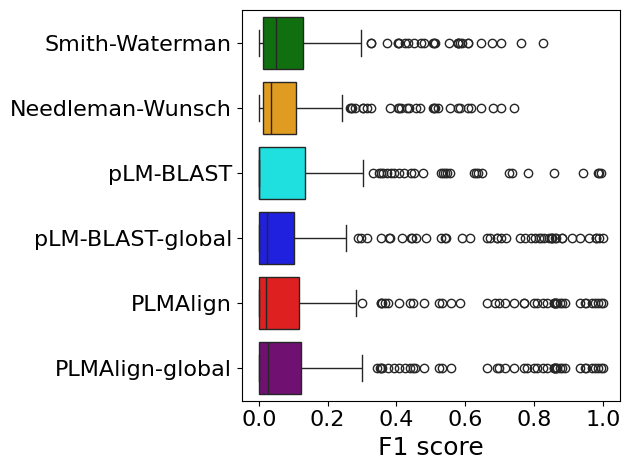

In [17]:
sns.boxplot(data=data.query("tool != 'HMMER' & tool != 'BLAST'"), 
            x='f1', y='tool', orient='h', palette=palette)
locs, labels = plt.xticks()
_ = plt.setp(labels, fontsize=16)

locs, labels = plt.yticks()
_ = plt.setp(labels, fontsize=16)

plt.xlabel('F1 score', fontsize=18)
plt.ylabel('')
plt.tight_layout()
plt.savefig(f'./data/alignment_benchmark/result/{benchmark}_f1_score.png')

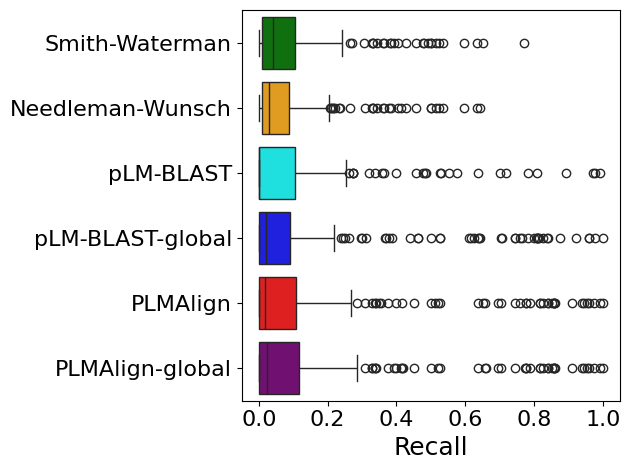

In [18]:
sns.boxplot(data=data.query("tool != 'HMMER' & tool != 'BLAST'"), 
            x='recall', y='tool', orient='h', palette=palette)
locs, labels = plt.xticks()
_ = plt.setp(labels, fontsize=16)

locs, labels = plt.yticks()
_ = plt.setp(labels, fontsize=16)

plt.xlabel('Recall', fontsize=18)
plt.ylabel('')
plt.tight_layout()
plt.savefig(f'./data/alignment_benchmark/result/{benchmark}_recall.png')

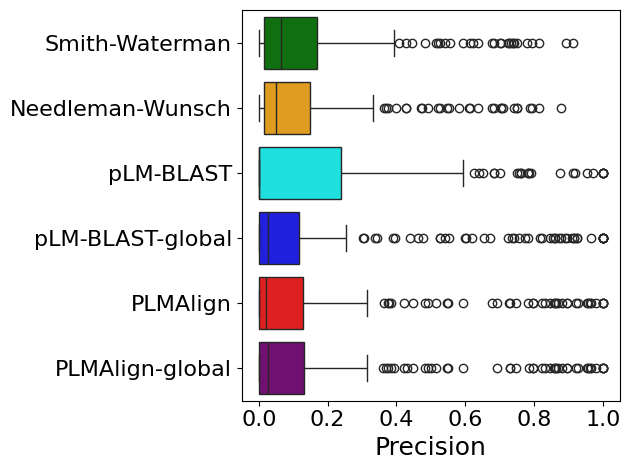

In [19]:
sns.boxplot(data=data.query("tool != 'HMMER' & tool != 'BLAST'"), 
            x='precision', y='tool', orient='h', palette=palette)
locs, labels = plt.xticks()
_ = plt.setp(labels, fontsize=16)

locs, labels = plt.yticks()
_ = plt.setp(labels, fontsize=16)

plt.xlabel('Precision', fontsize=18)
plt.ylabel('')
plt.tight_layout()
plt.savefig(f'./data/alignment_benchmark/result/{benchmark}_precision.png')

In [20]:
print(data.groupby(['tool']).mean()['f1'])

tool
BLAST               0.013335
HMMER               0.038736
Needleman-Wunsch    0.100013
PLMAlign            0.152734
PLMAlign-global     0.157068
Smith-Waterman      0.114798
pLM-BLAST           0.108859
pLM-BLAST-global    0.152625
Name: f1, dtype: float64


In [21]:
print(data.groupby(['tool']).agg(sem)['f1'])

tool
BLAST               0.013334
HMMER               0.026471
Needleman-Wunsch    0.009853
PLMAlign            0.017971
PLMAlign-global     0.017921
Smith-Waterman      0.010779
pLM-BLAST           0.013180
pLM-BLAST-global    0.017719
Name: f1, dtype: float64


In [22]:
print(data.groupby(['tool']).mean()['recall'])

tool
BLAST               0.006897
HMMER               0.021189
Needleman-Wunsch    0.081090
PLMAlign            0.147108
PLMAlign-global     0.151516
Smith-Waterman      0.094131
pLM-BLAST           0.091270
pLM-BLAST-global    0.139539
Name: recall, dtype: float64


In [23]:
print(data.groupby(['tool']).agg(sem)['recall'])

tool
BLAST               0.006897
HMMER               0.014557
Needleman-Wunsch    0.008208
PLMAlign            0.017485
PLMAlign-global     0.017459
Smith-Waterman      0.009117
pLM-BLAST           0.012112
pLM-BLAST-global    0.016619
Name: recall, dtype: float64


In [24]:
print(data.groupby(['tool']).mean()['precision'])

tool
BLAST               0.200000
HMMER               0.234375
Needleman-Wunsch    0.131655
PLMAlign            0.159294
PLMAlign-global     0.163481
Smith-Waterman      0.148377
pLM-BLAST           0.159108
pLM-BLAST-global    0.170027
Name: precision, dtype: float64


In [25]:
print(data.groupby(['tool']).agg(sem)['precision'])

tool
BLAST               0.200000
HMMER               0.153888
Needleman-Wunsch    0.012507
PLMAlign            0.018539
PLMAlign-global     0.018452
Smith-Waterman      0.013381
pLM-BLAST           0.017216
pLM-BLAST-global    0.019141
Name: precision, dtype: float64
